In [6]:
!pip3 install torchrl
!pip3 install gym[mujoco]
!pip3 install tqdm

In [7]:
from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (Compose, DoubleToFloat, ObservationNorm, StepCounter,
                          TransformedEnv)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, set_exploration_mode
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

In [8]:
# 하이퍼 파라미터 정의

device = "cpu" if not torch.has_cuda else "cuda:0"
num_cells = 256  # number of cells in each layer i.e. output dim.
lr = 3e-4
max_grad_norm = 1.0

In [9]:
# 데이터 수집 매개변수

frame_skip = 1
# 동일한 동작을 여러번 반복하는 것이 동작을 더 일관되고 덜 불규칙하게 만들기 때문에 유익할 수 있음
# 그러나 많은 frame을 skip할 경우, 변화 관찰에 대한 반응성을 감소시키기 때문에 모델 학습을 방해할 수 있음

## frame_skip을 사용할 때 다른 프레임 수를 함께 그룹화하는 프레임 수로 수정하는 것이 좋음
frames_per_batch = 1000 // frame_skip
# 전체 교육을 위해 frame 개수를 최대 1m개까지 가져옴
total_frames = 50_000 // frame_skip

In [10]:
# PPO 매개변수

## 각 데이터 collection에서 특정 epoch에 걸쳐 optimization 진행
## nested training loop에서 획득한 전체 데이터 소비
## sub_batch_size != frames_per_batch
## frames_per_batch에 의해 크기가 정해진 collector에서 나오는 data batch로 작업
## inner training loop 동안 더 작은 sub batch로 추가 분할 -> sub_batch_size로 크기 조절

sub_batch_size = 64  # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 10  # optimization steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

In [12]:
# 환경 정의
## gym.make(env_name, **kwargs)를 통해 직접 환경 정의 가능

base_env = GymEnv("InvertedDoublePendulum-v4", device=device, frame_skip=frame_skip)

### 우리만의 task를 진행하기 위해 어떻게 환경을 정의해야하지..?

In [13]:
# 변환 & 표준화

## policy에 대한 데이터 준비 위해 환경 변환 진행
## TransformedEnv 통해 변환 추가 가능

## 정규화 변환 : ObservationNorm
## Double 형태를 policy에서 읽을 수 있는 Float으로 변환 : DoubleToFloat
## 환경 종료 전 step 계산 위해 : StepCounter 활용
### TensorDict 중 'observation' 키에 해당하는 데이터만 변환하도록 : in_keys = ['observation']

env = TransformedEnv(
    base_env,
    Compose(
        # normalize observations
        ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(in_keys=["observation"]),
        StepCounter(),
    ),
)

In [14]:
env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)

In [15]:
# do a little sanity check
print("normalization constant shape:", env.transform[0].loc.shape)

normalization constant shape: torch.Size([11])


In [16]:
print("observation_spec:", env.observation_spec) # environment에서 action 수행 시 기대되는 실행
print("reward_spec:", env.reward_spec) # reward 도메인
print("input_spec:", env.input_spec) # environment가 각 single step 실행시 필요한 모든 것
print("action_spec (as defined by input_spec):", env.action_spec)

observation_spec: CompositeSpec(
    observation: UnboundedContinuousTensorSpec(
         shape=torch.Size([11]), space=None, device=cuda:0, dtype=torch.float32, domain=continuous),
    step_count: UnboundedDiscreteTensorSpec(
         shape=torch.Size([1]), space=ContinuousBox(minimum=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, contiguous=True), maximum=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, contiguous=True)), device=cuda:0, dtype=torch.int64, domain=continuous), device=cuda:0, shape=torch.Size([]))
reward_spec: UnboundedContinuousTensorSpec(
     shape=torch.Size([1]), space=ContinuousBox(minimum=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True), maximum=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True)), device=cuda:0, dtype=torch.float32, domain=continuous)
input_spec: CompositeSpec(
    action: BoundedTensorSpec(
         shape=torch.Size([1]), space=ContinuousBox(minimum=Tensor(

In [17]:
# 환경 잘 정의되었는지 check
check_env_specs(env)

check_env_specs succeeded!


In [18]:
# 각 단계에서 action을 입력으로 받아 observation, reward, done state 반환
# observations : 하나 이상의 tensor로 구성될 수 있음

rollout = env.rollout(3)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of three steps: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
                observation: Tensor(shape=torch.Size([3, 11]), device=cuda:0, dtype=torch.float32, is_shared=True),
                reward: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                step_count: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.int64, is_shared=True)},
            batch_size=torch.Size([3]),
            device=cuda:0,
            is_shared=True),
        observation: Tensor(shape=torch.Size([3, 11]), device=cuda:0, dtype=torch.float32, is_shared=True),
        step_count: Tensor(shape=torch.Size([3, 1]), devi

In [31]:
rollout['next']['observation']

tensor([[-0.0872, -0.1599, -0.2040,  0.6881,  0.7174,  0.6203, -0.5235,  0.4671,
          0.0000,  0.0000,  0.0000],
        [ 0.3227, -0.5674,  0.1731,  0.4700,  0.6756,  1.0458, -0.9786,  0.9426,
          0.0000,  0.0000,  0.0000],
        [ 0.6873, -0.9578,  0.5544,  0.0441,  0.4510,  0.4399, -0.5222,  0.5678,
          0.0000,  0.0000,  0.0000]], device='cuda:0')

In [32]:
rollout['next']['reward']

tensor([[9.3255],
        [9.2464],
        [9.2712]], device='cuda:0')

In [33]:
# Policy

actor_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(2 * env.action_spec.shape[-1], device=device),
    NormalParamExtractor(),
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [35]:
# 정책이 tensordict 데이터 운반책을 통해 환경과 대화할 수 있도록
## nn.Module 내의 TensorDictModule로 데이터 포장

policy_module = TensorDictModule(
    actor_net, in_keys=["observation"], out_keys=["loc", "scale"]
)

In [36]:
policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "min": env.action_spec.space.minimum,
        "max": env.action_spec.space.maximum, # 환경 사양에서 수집한 분포의 최소 최대 활용
    },
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
)

In [37]:
# Value network
## observation 내용을 읽고 다음 trajectory에 대한 discounted return 추정치 반환
## 훈련 중 즉석에서 학습되는 일부 utility 추정에 의존하여 학습 양도(?) 가능
value_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),
)

value_module = ValueOperator(
    module=value_net,
    in_keys=["observation"],
)

In [38]:
print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        loc: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        observation: Tensor(shape=torch.Size([11]), device=cuda:0, dtype=torch.float32, is_shared=True),
        sample_log_prob: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.float32, is_shared=True),
        scale: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        step_count: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, is_shared=True)},
    batch_size=torch.Size([]),
    device=cuda:0,
    is_shared=True)
Running value: TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        observation: Tensor(shape=torch.Size([11]), de

In [39]:
# Data Collector
## 환경 설정
## 최신 observation이 주어진 action 계산
## 환경에서 step 실행

collector = SyncDataCollector( # 주어진 길이의 data batch를 가져올 때 활용
    env,
    policy_module,
    frames_per_batch=frames_per_batch, # 수집할 프레임 수 정의
    total_frames=total_frames, # 총 프레임 수가 total_frames가 되면 수집 종료
    split_trajs=False,
    device=device,
)


In [40]:
# Replay buffer
## off-policy 강화학습 알고리즘의 공통 구성 요소
## 버퍼의 구성요소 (storage, writer, sampler 등)를 인수로 취하는 공통 컨테이너를 통해 구축됨
## storage만이 필수 인수

# replay buffer를 활용하는 것은 필수가 아님
# 수집된 batch에서 sub batch를 간단히 샘플링할 수 있으나
# 이 클래스를 활용하면 재현 가능한 방식으로 inner training loop 구축 가능

replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

In [41]:
# 손실 함수

## PPO 손실을 TorchRL에서 직접 가져올 수 있음 (ClipPPOLoss)

advantage_module = GAE( # tensordict신규 "advantage"및 "value_target"항목으로 입력을 업데이트
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True
)

loss_module = ClipPPOLoss(
    actor=policy_module,
    critic=value_module,
    advantage_key="advantage",
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys match by default but we set this for completeness
    value_target_key=advantage_module.value_target_key,
    # "value_target" : 네트워크가 입력 관찰로 나타내야 하는 경험적 값을 나타내는 기울기가 없는 텐서
    critic_coef=1.0,
    gamma=0.99,
    loss_critic_type="smooth_l1",
)

## 가치 손실, 정책 손실 모두 반환

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 0.0
)

/usr/local/lib/python3.10/dist-packages/torchrl/objectives/ppo.py:163: DeprecationWarning: Passing gamma / lambda parameters through the loss constructor is deprecated and will be removed soon. To customize your value function, run `loss_module.make_value_estimator(ValueEstimators.<value_fun>, gamma=val)`.
  warnings.warn(_GAMMA_LMBDA_DEPREC_WARNING, category=DeprecationWarning)


In [43]:
# training loop

logs = defaultdict(list)
pbar = tqdm(total=total_frames * frame_skip)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optimization step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel() * frame_skip)
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our ``env`` horizon).
        # The ``rollout`` method of the ``env`` can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_mode("mean"), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()


  0%|          | 0/50000 [00:13<?, ?it/s]

  2%|▏         | 1000/50000 [00:06<05:15, 155.28it/s]/usr/local/lib/python3.10/dist-packages/tensordict/nn/probabilistic.py:79: DeprecationWarning: set_interaction_mode is deprecated for naming clarity. Please use set_interaction_type with InteractionType enum instead.
  _insert_interaction_mode_deprecation_warning("set_")

eval cumulative reward:  101.5317 (init:  101.5317), eval step-count: 10, average reward= 9.0900 (init= 9.0900), step count (max): 10, lr policy:  0.0003:   2%|▏         | 1000/50000 [00:06<05:15, 155.28it/s]
eval cumulative reward:  101.5317 (init:  101.5317), eval step-count: 10, average reward= 9.0900 (init= 9.0900), step count (max): 10, lr policy:  0.0003:   2%|▏         | 1000/50000 [00:16<05:15, 155.28it/s]
eval cumulative reward:  101.5317 (init:  101.5317), eval step-count: 10, average reward= 9.0900 (init= 9.0900), step count (max): 10, lr policy:  0.0003:   4%|▍         | 2000/50000 [00:19<08:03, 99.35it/s] 
eva

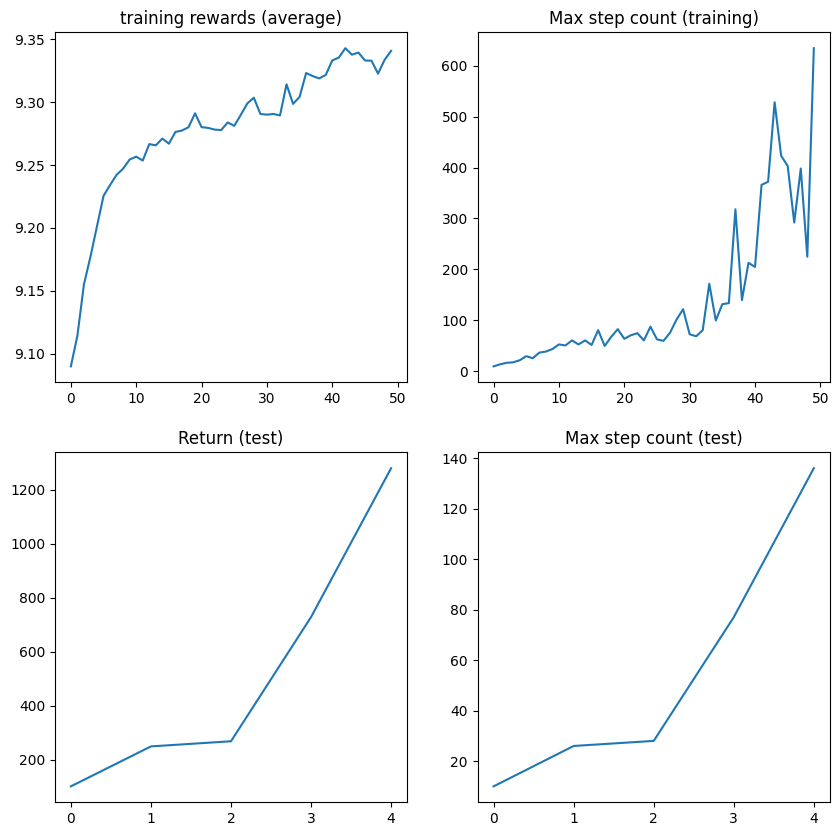

In [44]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()